In [1]:
import xml.etree.ElementTree as ET
import os
import numpy as np
import subprocess
from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange
from collections import defaultdict


In [2]:
bm_folder = '../benchmarks/'
file_name = 'sparcT1_core_stratixiv_arch_timing'
path_blif = os.path.join(bm_folder, 'blif',file_name +'.blif')
path_graphfiles_folder = os.path.join(bm_folder,'graphfile' ,file_name)
arch_name = 'stratixiv_arch.timing.xml'
path_arch_folder = os.path.join(bm_folder,'architecture' ,arch_name)
path_log_file = os.path.join(bm_folder, 'misc','vpr_stdout' +'.log')
hmetis = 'hmetis-1.5-linux/hmetis'
if not os.path.isdir(path_graphfiles_folder):
    os.mkdir(path_graphfiles_folder)

tree = ET.parse(path_arch_folder)
root = tree.getroot()

In [3]:
for child in root:
    print(child.tag, child.attrib)

models {}
tiles {}
layout {}
device {}
switchlist {}
segmentlist {}
directlist {}
complexblocklist {}
switchblocklist {}


In [4]:
attributes = set([])
arch_models = root.findall('.//models/model')
for model in root.findall('.//models/model'):
#     print(elem.attrib.get('name'))
    for ports in model:
        for port in ports:
            attributes = attributes.union(set(port.attrib.keys()))
attributes

{'clock', 'combinational_sink_ports', 'is_clock', 'name'}

In [5]:
len(arch_models)

196

# Subckt 49843: sparc_ifu:ifu|bw_r_idct:ict|bw_r_idct_array:ictag_ary_01|altsyncram:array_rtl_0|altsyncram_6dp1:auto_generated|ram_block1a2~I 
.subckt stratixiv_ram_block.opmode{dual_port}.output_type{comb}.port_a_address_width{7}.port_b_address_width{7} \
    portbaddr[0]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[5] \
    portbaddr[1]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[6] \
    portbaddr[2]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[7] \
    portbaddr[3]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[8] \
    portbaddr[4]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[9] \
    portbaddr[5]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[10] \
    portbaddr[6]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[11] \
    portawe=sparc_ifu:ifu|bw_r_idct:ict|we[1]~3 \
    portbre=vcc \
    portaaddr[0]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[5] \
    portaaddr[1]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[6] \
    portaaddr[2]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[7] \
    portaaddr[3]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[8] \
    portaaddr[4]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[9] \
    portaaddr[5]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[10] \
    portaaddr[6]=sparc_ifu:ifu|bw_r_icd:icd|wr_index0[11] \
    ena1=sparc_ifu:ifu|bw_r_idct:ict|we[1]~3 \
    ena0=sparc_ifu:ifu|bw_r_idct:ict|we[1]~3 \
    ena3=vcc \
    ena2=vcc \
    clk_portain=gclk \
    clk_portbin=gclk \
    portadatain=sparc_ifu:ifu|sparc_ifu_ifqdp:ifqdp|dff_s:wraddr_reg|q[10] \
    portbdataout=sparc_ifu:ifu|bw_r_idct:ict|bw_r_idct_array:ictag_ary_01|altsyncram:array_rtl_0|altsyncram_6dp1:auto_generated|ram_block1a2


In [6]:
names = []
subckt = 'stratixiv_lcell_comb'
for model in root.findall('.//models/model'):
    if subckt in model.attrib.get('name'):
        
        for ports in model:
            print(ports.tag, 'ports')
            for port in ports:
#                 for key, val in port.attrib.items():
#                     print(key, val)
                print(port.tag, port.attrib)


input_ports ports
port {'name': 'dataa', 'combinational_sink_ports': 'combout sumout cout shareout'}
port {'name': 'datab', 'combinational_sink_ports': 'combout sumout cout shareout'}
port {'name': 'datac', 'combinational_sink_ports': 'combout sumout cout shareout'}
port {'name': 'datad', 'combinational_sink_ports': 'combout sumout cout shareout'}
port {'name': 'datae', 'combinational_sink_ports': 'combout'}
port {'name': 'dataf', 'combinational_sink_ports': 'combout sumout cout'}
port {'name': 'datag', 'combinational_sink_ports': 'combout'}
port {'name': 'cin', 'combinational_sink_ports': 'sumout cout'}
port {'name': 'sharein', 'combinational_sink_ports': 'sumout cout'}
output_ports ports
port {'name': 'combout'}
port {'name': 'sumout'}
port {'name': 'cout'}
port {'name': 'shareout'}


### Find loops

In [7]:
file1 = open(path_log_file)
lines = file1.readlines()
lines

['net \n',
 'source \n',
 'block: n0, model: .input, is_combinational: true ,pin: n0.inpad[0] \n',
 'sinks n0 \n',
 'block: n11408, model: dffeas, is_combinational: false ,pin: n11408.ena[0] \n',
 'block: n29325, model: stratixiv_ram_block.opmode{dual_port}.output_type{comb}.port_a_address_width{8}.port_b_address_width{8}, is_combinational: false ,pin: n29325.portaaddr[4] \n',
 'block: n41649, model: stratixiv_lcell_comb, is_combinational: true ,pin: n41649.datab[0] \n',
 'block: n40964, model: stratixiv_lcell_comb, is_combinational: true ,pin: n40964.dataa[0] \n',
 'block: n44463, model: stratixiv_lcell_comb, is_combinational: true ,pin: n44463.dataa[0] \n',
 'block: n44420, model: stratixiv_lcell_comb, is_combinational: true ,pin: n44420.dataa[0] \n',
 'block: n54620, model: dffeas, is_combinational: false ,pin: n54620.ena[0] \n',
 'block: n54633, model: stratixiv_ram_block.opmode{dual_port}.output_type{comb}.port_a_address_width{5}.port_b_address_width{5}, is_combinational: false ,p

In [8]:
nets = []
comb_blocks = defaultdict(bool)
index1 = 0
for index2, line in enumerate(lines):
    if 'block:' == line[:len('block:')]:
        block_str, type_str, comb_str, _ = line.split(',')
        if (comb_str.split()[1] == 'true' or 'ram' in type_str.split()[1]) and not (type_str.split()[1] == '.input' or type_str.split()[1] == '.output'):
            comb_blocks[block_str.split()[1]] = True
        else:
            comb_blocks[block_str.split()[1]] = False
    if 'net' == line[:3]:
        nets.append(lines[index1:index2])
        index1 = index2
nets.append(lines[index1:])

In [9]:
sum(list(comb_blocks.values()))

46741

In [10]:
# Python program to find strongly connected components in a given
# directed graph using Tarjan's algorithm (single DFS)
#Complexity : O(V+E)

# This class represents an directed graph
# using adjacency list representation

class Graph:

        def __init__(self, vertices):
            # No. of vertices
            self.V = vertices

            # default dictionary to store graph
            self.graph = defaultdict(list)

            self.Time = 0
            
        # function to add an edge to graph
        def addEdge(self, u, v):
            self.graph[u].append(v)

        '''A recursive function that find finds and prints strongly connected
        components using DFS traversal
        u --> The vertex to be visited next
        disc[] --> Stores discovery times of visited vertices
        low[] -- >> earliest visited vertex (the vertex with minimum
                    discovery time) that can be reached from subtree
                    rooted with current vertex
        st -- >> To store all the connected ancestors (could be part
            of SCC)
        stackMember[] --> bit/index array for faster check whether
                    a node is in stack
        '''

        def SCCUtil(self, u, low, disc, stackMember, st, sccs, cc):

            # Initialize discovery time and low value
            disc[u] = self.Time
            cc.append(u)
            low[u] = self.Time
            self.Time += 1
            stackMember[u] = True
            st.append(u)

            # Go through all vertices adjacent to this
            for v in self.graph[u]:

                # If v is not visited yet, then recur for it
                if disc[v] == -1:

                    self.SCCUtil(v, low, disc, stackMember, st, sccs, cc)

                    # Check if the subtree rooted with v has a connection to
                    # one of the ancestors of u
                    # Case 1 (per above discussion on Disc and Low value)
                    low[u] = min(low[u], low[v])

                elif stackMember[v] == True:

                    '''Update low value of 'u' only if 'v' is still in stack
                    (i.e. it's a back edge, not cross edge).
                    Case 2 (per above discussion on Disc and Low value) '''
                    low[u] = min(low[u], disc[v])

            # head node found, pop the stack and print an SCC
            w = -1 # To store stack extracted vertices
            if low[u] == disc[u]:
                scc = []
                while w != u:
                    w = st.pop()
#                     print(w, end=" ")
                    scc.append(w)
                    stackMember[w] = False
                sccs.append(scc)
                
#                 print()

        # The function to do DFS traversal.
        # It uses recursive SCCUtil()

        def SCC(self):

            # Mark all the vertices as not visited
            # and Initialize parent and visited,
            # and ap(articulation point) arrays
            disc = [-1] * (self.V)
            low = [-1] * (self.V)
            stackMember = [False] * (self.V)
            st = []
            
            sccs = []
            ccs = []
            
            # Call the recursive helper function
            # to find articulation points
            # in DFS tree rooted with vertex 'i'
            for i in range(self.V):
                cc = []
                if disc[i] == -1:
                    self.SCCUtil(i, low, disc, stackMember, st, sccs, cc)
                    ccs.append(cc)
            return sccs, ccs
        
        def DFS(self, u, visited):
            visited[u] = True
            children = []
            for v in self.graph[u]:
                if not visited[v]:
                    children.append(v)
                    children.extend(self.DFS(v, visited))                
            return children
            
        def get_descendants(self, u):
            visited = [False] * (self.V)
            return self.DFS(u, visited)
                
                

# Create a graph given in the above diagram
g2 = Graph(4)
g2.addEdge(0, 1)
g2.addEdge(2, 3)
g2.addEdge(0, 3)
print("\nSSC in second graph ")
g2.SCC()
g2.get_descendants(0)


SSC in second graph 


[1, 3]

In [11]:
indices = np.arange(len(comb_blocks))
comb_blocks_index = dict(zip(comb_blocks.keys(), indices))
index_comb_blocks = dict(zip(indices, comb_blocks.keys()))

In [12]:
len(nets)

93545

In [13]:
# Create a graph given in the above diagram
graph = Graph(len(comb_blocks))

for i, net in enumerate(nets):
    if not net == []:
        source_line = net[2]
        sink_lines = net[4:]
        block_str, type_str, comb_str, pin = source_line.strip().split(',')
        block = block_str.split()[1]
        if comb_blocks[block]:
            source = comb_blocks_index[block]
            for sink_line in sink_lines:
                block_str, type_str, comb_str, pin = sink_line.strip().split(',')
                block = block_str.split()[1]
                if comb_blocks[block]:
                    sink = comb_blocks_index[block]
                    graph.addEdge(source, sink)


In [14]:
sccs, ccs = graph.SCC()

In [15]:
loops = [scc for scc in sccs if len(scc) > 1]
loops

[[4311,
  75365,
  72261,
  76451,
  76098,
  27387,
  58020,
  27321,
  76426,
  76501,
  76500,
  76454,
  76569,
  76207,
  76568,
  76540],
 [53855,
  23434,
  58330,
  58328,
  64073,
  71693,
  24261,
  24260,
  71688,
  71462,
  61510,
  71691,
  70241,
  74917,
  74748,
  74717,
  74685,
  74382,
  73931,
  74232,
  74229,
  74291,
  74228,
  74257,
  74248,
  74213,
  74097,
  72154,
  27093,
  75421,
  73258,
  71063,
  73257,
  59364,
  68760,
  54402,
  62595,
  23376,
  73051,
  23356,
  71229,
  71228,
  73256,
  72654,
  3605,
  71231,
  70511,
  71254,
  72808,
  71093,
  73277,
  73304,
  71092,
  72807,
  73025,
  54830,
  73225,
  71078,
  71090,
  23286,
  72427,
  73110,
  71449,
  73070,
  73015,
  23080,
  60454,
  23079,
  23078,
  812,
  63907,
  66642,
  66641,
  58945,
  58733,
  56235,
  5361,
  60812,
  333,
  332,
  54640,
  60781,
  58366,
  60366,
  61119,
  60664,
  58713,
  60262,
  12486,
  59711,
  59710,
  59709,
  59707,
  10381,
  60357,
  59719,


## circuit

In [16]:
file1 = open(path_blif, 'r')
lines = file1.readlines()

### 1) parse models (except for main)

In [17]:
# Strips the newline character
models = []
index1 = 0
for index2, line in enumerate(lines):
    if '.model' in line:
        models.append(lines[index1:index2])
        index1 = index2
models.append(lines[index1:])
main_model = models[1]
subckt_models = models[2:]

In [18]:
subckt_model = subckt_models[0]
subckt_model[0].split()[1]

for subckt_model in subckt_models:
    subckt_name = subckt_model[0].split()[1]
    for arch_model in arch_models:
        if subckt_name == arch_model.attrib.get('name'):
            arch_model.attrib.get('name')

In [19]:
class Subckt:
    def __init__(self, name, inputs, outputs):
        self.data_inputs = []
        self.ctrl_inputs = []
        self.inputs = inputs
        self.outputs = outputs
        self.name = name
    
    

In [20]:
subckts = {}

for subckt_model in subckt_models:
    input_line, output_line = False, False
    inputs = []
    outputs = []
    for line in subckt_model:
        if '.model' in line:
            name = line.split()[1]
        if '.inputs' in line:
            input_line = True
            output_line = False
        elif '.outputs' in line:
            input_line = False
            output_line = True 
        elif line[0] == '.':
            input_line = False
            output_line = False
        elif input_line:
            inputs.append(line.split()[0])
        elif output_line:
            outputs.append(line.split()[0])
    
    subckts[name] = Subckt(name, inputs, outputs)
    

 Dffs: complete input="alm.data_in" name="in_comp1" output="lut[1:0].lin dff[1:0].d dff[1:0].ena dff[1:0].asdata"

In [21]:
for subckt in subckts.values():
    for input_ in subckt.inputs:
        if 'data' in input_:
            subckt.data_inputs.append(input_)
        else:
            subckt.ctrl_inputs.append(input_)
            
subckts['dffeas'].ctrl_inputs.remove('d')
subckts['dffeas'].ctrl_inputs.remove('ena')
subckts['dffeas'].data_inputs.append('d')
subckts['dffeas'].data_inputs.append('ena')

In [22]:
# for subckt in subckts.values():
#     print(subckt.name)
#     print('CTRL')
#     print('\t', subckt.ctrl_inputs)
#     print('DATA')
#     print('\t', subckt.data_inputs) 
#     print('OUTPUTS')
#     print('\t', subckt.outputs) 
    

In [23]:
for subckt in subckts.values():
    print(subckt.name, len(subckt.inputs), len(subckt.outputs))

stratixiv_mac_out.opmode{36_bit_multiply}.input_type{comb}.output_type{comb} 156 73
stratixiv_mac_mult.input_type{comb} 48 54
stratixiv_ram_block.opmode{rom}.output_type{comb}.port_a_address_width{8} 18 1
stratixiv_ram_block.opmode{dual_port}.output_type{comb}.port_a_address_width{4}.port_b_address_width{4} 31 4
stratixiv_ram_block.opmode{dual_port}.output_type{comb}.port_a_address_width{5}.port_b_address_width{5} 33 4
stratixiv_ram_block.opmode{dual_port}.output_type{comb}.port_a_address_width{7}.port_b_address_width{7} 37 4
stratixiv_ram_block.opmode{dual_port}.output_type{comb}.port_a_address_width{8}.port_b_address_width{8} 39 4
dffeas 11 1
stratixiv_lcell_comb 9 4


In [24]:
new_main_model = []

new_line_split = []
for line in main_model:
    line_split = line.split()
    if line_split != [] and (line_split[-1] == '\\'):
        new_line_split.extend(line_split[:-1])
#     elif line_split != [] and (line_split[0]=='.names' or line_split[0] == '0' or line_split[0] == '1'):
#         new_line_split.extend(line_split)
    else:
        new_line_split.extend(line_split)
        new_line = ' '.join(new_line_split)
        new_main_model.append(new_line_split)
        new_line_split = []
new_main_model

[['.model', 'sparc'],
 ['.inputs',
  'pcx_spc_grant_px[0]',
  'pcx_spc_grant_px[1]',
  'pcx_spc_grant_px[2]',
  'pcx_spc_grant_px[3]',
  'pcx_spc_grant_px[4]',
  'cpx_spc_data_rdy_cx2',
  'cpx_spc_data_cx2[0]',
  'cpx_spc_data_cx2[1]',
  'cpx_spc_data_cx2[2]',
  'cpx_spc_data_cx2[3]',
  'cpx_spc_data_cx2[4]',
  'cpx_spc_data_cx2[5]',
  'cpx_spc_data_cx2[6]',
  'cpx_spc_data_cx2[7]',
  'cpx_spc_data_cx2[8]',
  'cpx_spc_data_cx2[9]',
  'cpx_spc_data_cx2[10]',
  'cpx_spc_data_cx2[11]',
  'cpx_spc_data_cx2[12]',
  'cpx_spc_data_cx2[13]',
  'cpx_spc_data_cx2[14]',
  'cpx_spc_data_cx2[15]',
  'cpx_spc_data_cx2[16]',
  'cpx_spc_data_cx2[17]',
  'cpx_spc_data_cx2[18]',
  'cpx_spc_data_cx2[19]',
  'cpx_spc_data_cx2[20]',
  'cpx_spc_data_cx2[21]',
  'cpx_spc_data_cx2[22]',
  'cpx_spc_data_cx2[23]',
  'cpx_spc_data_cx2[24]',
  'cpx_spc_data_cx2[25]',
  'cpx_spc_data_cx2[26]',
  'cpx_spc_data_cx2[27]',
  'cpx_spc_data_cx2[28]',
  'cpx_spc_data_cx2[29]',
  'cpx_spc_data_cx2[30]',
  'cpx_spc_data_cx

In [25]:
# collect .inputs, .outputs, .names, .latch, .subckt
inputs_main = None
outputs_main = None
names_main = []
latches_main = []
subckts_main = []

for split_line in new_main_model:
    if split_line == []:
        pass
    elif split_line[0] == '.inputs':
        inputs_main = split_line
    elif split_line[0] == '.outputs':
        outputs_main = split_line
    elif split_line[0] == '.names': 
        names_main.append(split_line)
    elif split_line[0] == '.latch':
        latches_main.append(split_line)
    elif split_line[0] == '.subckt':
        subckts_main.append(split_line)

In [26]:
subckts_main

[['.subckt',
  'dffeas',
  'd=sparc_ifu:ifu|sparc_ifu_fcl:fcl|dff_s:thrf_reg|q[0]',
  'clk=gclk',
  'q=sparc_ifu:ifu|sparc_ifu_fcl:fcl|dff_s:thrd_reg|q[0]'],
 ['.subckt',
  'dffeas',
  'd=sparc_ifu:ifu|sparc_ifu_fcl:fcl|flush_pipe_w',
  'clk=gclk',
  'q=sparc_ifu:ifu|sparc_ifu_fcl:fcl|dff_s:fp_ff|q[0]'],
 ['.subckt',
  'stratixiv_lcell_comb',
  'datab=sparc_ifu:ifu|sparc_ifu_fcl:fcl|dffr_s:thre2_reg|q[3]',
  'dataa=sparc_ifu:ifu|sparc_ifu_fcl:fcl|dff_s:thrw_reg|q[3]',
  'combout=sparc_ifu:ifu|sparc_ifu_fcl:fcl|thr_match_ew~0'],
 ['.subckt',
  'dffeas',
  'd=cmp_grst_l',
  'clk=gclk',
  'q=bw_clk_cl_sparc_cmp:spc_hdr|cluster_header:I0|cluster_grst_l'],
 ['.subckt',
  'dffeas',
  'd=bw_clk_cl_sparc_cmp:spc_hdr|cluster_header:I0|cluster_grst_l',
  'clrn=cmp_arst_l',
  'clk=gclk',
  'q=sparc_ffu:ffu|sparc_ffu_ctl:ctl|dffrl_async:rstff|q[0]'],
 ['.subckt',
  'dffeas',
  'd=sparc_ifu:ifu|sparc_ifu_fcl:fcl|dff_s:thrd_reg|q[0]',
  'sclr=sparc_ffu:ffu|sparc_ffu_ctl:ctl|dffrl_async:rstff|q[0]',


## I/O count

In [27]:
pd.DataFrame()

""


In [28]:
subckt_collection = [] #[[subckt_name, inputs, clk, outputs]]
circuit_atoms = []
counts = []
for subckt in subckts_main:
        #subckt first: '.subckt', second: 'name', then 'IO_name=netname'
        name = subckt[1]
        ins = {}
        clks = []
        outs = {}
        for io_net in subckt[2:]:
            port, net = io_net.split('=')
            if port in subckts[name].inputs:
                if 'clk' in port:
                    clks.append(port)
                else:
                    ins[port] = net
            elif port in subckts[name].outputs:
                outs[port]= net
        
        input_ports = list(ins)
        output_ports = list(outs)
        circuit_atoms.append([name, ins, clks, outs])
        if not [name, input_ports, clks, output_ports] in subckt_collection:
            subckt_collection.append([name, input_ports, clks, output_ports])
            counts.append(1)
        else:
            i = subckt_collection.index([name, input_ports, clks, output_ports])
            counts[i] += 1

In [29]:
for subckt, count in zip(subckt_collection, counts):
    name = subckt[0]
    inputs = subckt[1]
    outputs = subckt[3]
    if name == 'stratixiv_lcell_comb' and 'cin' in inputs and not 'cout' in outputs:
        print(count, subckt)

1 ['stratixiv_lcell_comb', ['cin', 'dataf'], [], ['sumout']]
5 ['stratixiv_lcell_comb', ['sharein', 'cin', 'datad', 'datac'], [], ['sumout']]
6 ['stratixiv_lcell_comb', ['cin', 'datad'], [], ['sumout']]
8 ['stratixiv_lcell_comb', ['cin'], [], ['sumout']]
2 ['stratixiv_lcell_comb', ['cin', 'dataf', 'datad', 'dataa'], [], ['sumout']]


### Collect Datapath and control path

In [30]:
len(outputs_main)

138

In [31]:
for subckt in subckts.values():
    print(subckt.name)
    for input_ in subckt.inputs:
        print('\t', input_)

stratixiv_mac_out.opmode{36_bit_multiply}.input_type{comb}.output_type{comb}
	 devpor
	 devclrn
	 aclr[0]
	 aclr[1]
	 aclr[2]
	 aclr[3]
	 ena[0]
	 ena[1]
	 ena[2]
	 ena[3]
	 signb
	 signa
	 datad[0]
	 datad[1]
	 datad[2]
	 datad[3]
	 datad[4]
	 datad[5]
	 datad[6]
	 datad[7]
	 datad[8]
	 datad[9]
	 datad[10]
	 datad[11]
	 datad[12]
	 datad[13]
	 datad[14]
	 datad[15]
	 datad[16]
	 datad[17]
	 datad[18]
	 datad[19]
	 datad[20]
	 datad[21]
	 datad[22]
	 datad[23]
	 datad[24]
	 datad[25]
	 datad[26]
	 datad[27]
	 datad[28]
	 datad[29]
	 datad[30]
	 datad[31]
	 datad[32]
	 datad[33]
	 datad[34]
	 datad[35]
	 datac[0]
	 datac[1]
	 datac[2]
	 datac[3]
	 datac[4]
	 datac[5]
	 datac[6]
	 datac[7]
	 datac[8]
	 datac[9]
	 datac[10]
	 datac[11]
	 datac[12]
	 datac[13]
	 datac[14]
	 datac[15]
	 datac[16]
	 datac[17]
	 datac[18]
	 datac[19]
	 datac[20]
	 datac[21]
	 datac[22]
	 datac[23]
	 datac[24]
	 datac[25]
	 datac[26]
	 datac[27]
	 datac[28]
	 datac[29]
	 datac[30]
	 datac[31]
	 datac[32]
	 da

In [32]:
block

'n92960'

In [33]:
nets = defaultdict(lambda: defaultdict(list))
for block_num, block in enumerate(comb_blocks):
    
    block_split = block.strip().split()
    gate = block_split[0]
    subckt_type, in_pins, clocks, out_pins = subckt_collection_gnl_version[list(gates_library).index(gate)]

    inputs = block_split[1:1+len(in_pins)]
    outputs = block_split[1+len(in_pins): ]
    assert len(out_pins) == len(outputs)
    if subckt_type != 'dffeas':
        for input_ in inputs:
            nets[input_]['sinks'].append(block_num)
        for output_ in outputs:
            nets[output_]['source'] = block_num

NameError: name 'subckt_collection_gnl_version' is not defined

In [34]:
# Create a graph given in the above diagram
graph = Graph(len(comb_blocks))

for net in nets.values():
    if net['source'] != []:
        source = net['source']
        for sink in net['sinks']:
            graph.addEdge(source, sink)

### Carry chains

In [35]:
# net --> atoms
carry_chain_nets = {}
for atom_index, atom in enumerate(circuit_atoms):
    name, ins, clk, outs = atom
    if 'cin' in ins:
        net = ins['cin']
        if not net in carry_chain_nets:
            carry_chain_nets[net] = set()
        carry_chain_nets[net].add(atom_index)
    if 'cout' in outs:
        net = outs['cout']
        if not net in carry_chain_nets:
            carry_chain_nets[net] = set()
        carry_chain_nets[net].add(atom_index)
#     if 'sharein' in ins:
#         net = ins['sharein']
#         if not net in carry_chain_nets:
#             carry_chain_nets[net] = set()
#         carry_chain_nets[net].add(atom_index)
#     if 'shareout' in outs:
#         net = outs['shareout']
#         if not net in carry_chain_nets:
#             carry_chain_nets[net] = set()
#         carry_chain_nets[net].add(atom_index)

In [36]:
carry_chains = []
start_atom_indices = carry_chain_nets['gnd']
carry_chain_nets.pop('gnd')
for start_atom_index in start_atom_indices:
    carry_chain = [start_atom_index]
    atom_index = start_atom_index
    atom_found = True
    while atom_found:
        atom_found = False
        for net, atom_indices in carry_chain_nets.items():
            if atom_index in atom_indices:
                atom_indices.remove(atom_index)
                atom_index = list(atom_indices)[0]
                atom_indices.remove(atom_index)
                carry_chain.append(atom_index)
                selected_net = net
                atom_found = True
        if atom_found:
            carry_chain_nets.pop(selected_net)
            
    carry_chains.append(carry_chain)

In [37]:
carry_chains

[[7169, 7170, 7195, 7785],
 [25985,
  27341,
  27342,
  27348,
  27354,
  27360,
  27366,
  29623,
  29629,
  29635,
  29641,
  29647,
  29653,
  29659,
  29665,
  29671,
  29677,
  29683,
  29689,
  29695,
  29701,
  29707,
  29713,
  29719,
  29725,
  34786,
  34792,
  34798,
  65787,
  65793,
  65799,
  65805,
  65808],
 [7173, 7174, 7197, 11099],
 [18950,
  18956,
  18962,
  18968,
  18974,
  18980,
  18986,
  18992,
  18998,
  19004,
  19010,
  19016,
  19022,
  19028,
  19034,
  19040,
  19046,
  19052,
  19058,
  27874,
  27880,
  27886,
  27892,
  27898,
  27904,
  27910,
  27916,
  27922,
  29845,
  29851,
  29857,
  29863,
  29869],
 [19720,
  19721,
  19722,
  19723,
  50859,
  19798,
  19799,
  21290,
  21291,
  21587,
  21596,
  59952,
  21426,
  21427,
  21428,
  50560,
  63335,
  63903],
 [7177, 7178, 7199, 87661],
 [14218,
  14393,
  59253,
  59254,
  59255,
  59256,
  59257,
  59258,
  59259,
  65018,
  65022,
  65023,
  65024,
  65040,
  65056,
  65072,
  65247,
  654

In [38]:
cc_distribution = [len(chain) for chain in carry_chains]
' '.join([str(num) for num in cc_distribution])

'4 33 4 33 18 4 46 34 5 74 17 76 34 34 18 6 6 63 21 34 4 17'

In [39]:
carry_chain = carry_chains[11]

In [40]:
len(carry_chains)

22

In [41]:
cc_distribution_simple = []
cc_distribution_double = []
for chain in carry_chains:
    first_atom_index = chain[0]
    ins = circuit_atoms[first_atom_index][1]
    if 'sharein' in ins:
        cc_distribution_double.append(len(chain))
    else:
        cc_distribution_simple.append(len(chain))
cc_distribution_double, cc_distribution_simple

([4, 4, 4, 6, 4],
 [33, 33, 18, 46, 34, 5, 74, 17, 76, 34, 34, 18, 6, 63, 21, 34, 17])

In [42]:
for atom_index in carry_chain:
    print(atom_index)
    print('din:', list(circuit_atoms[atom_index][1]))
    print('dout:', list(circuit_atoms[atom_index][3]))

18479
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18480
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18481
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18482
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18483
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18484
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18485
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18486
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18487
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18488
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18489
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18490
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18491
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18492
din: ['cin', 'dataf', 'datad', 'dataa']
dout: ['cout', 'sumout']
18493


In [43]:
carry_chain_ports = ['cin', 'sharein', 'cout', 'shareout']

In [44]:
#labels:
#'simple_chain' -> [cin, cout]
#'simple_end' -> [cin]
#'double_chain' -> [cin, sharein, cout, shareout]
#'double_end' -> [cin, sharein]

carry_chain_labels = []

In [45]:
subckt_collection_cclabels = []
for name, input_ports, clks, output_ports in subckt_collection:
    label = None
    if 'cin' in input_ports:
        if 'sharein' in input_ports:
            if 'cout' in output_ports:
                label = 'double_chain'
            else:
                label = 'double_end'
        else:
            if 'cout' in output_ports:
                label = 'simple_chain'
            else:
                label = 'simple_end'
    subckt_collection_cclabels.append(label)

In [46]:
for subckt, count in zip(subckt_collection, counts):
    name = subckt[0]
    inputs = subckt[1]
    outputs = subckt[3]
    if name == 'stratixiv_lcell_comb' and 'cin' in inputs and not 'cout' in outputs:
        print(count, subckt)

1 ['stratixiv_lcell_comb', ['cin', 'dataf'], [], ['sumout']]
5 ['stratixiv_lcell_comb', ['sharein', 'cin', 'datad', 'datac'], [], ['sumout']]
6 ['stratixiv_lcell_comb', ['cin', 'datad'], [], ['sumout']]
8 ['stratixiv_lcell_comb', ['cin'], [], ['sumout']]
2 ['stratixiv_lcell_comb', ['cin', 'dataf', 'datad', 'dataa'], [], ['sumout']]


### Special nets

gnd, vcc

In [47]:
# net --> port
nets_in_ports = {}
nets_out_ports = {}
ports_nets = {}
for atom in circuit_atoms:
    name, ins, clks, outs = atom
    for port, net in ins.items():
        if not net in nets_in_ports:
            nets_in_ports[net] = []
        nets_in_ports[net].append(port)
        if not port in ports_nets:
            ports_nets[port] = []
        ports_nets[port].append(net)
    for port, net in outs.items():
        if not net in nets_out_ports:
            nets_out_ports[net] = []
        nets_out_ports[net].append(port)

In [48]:
inputs_main

['.inputs',
 'pcx_spc_grant_px[0]',
 'pcx_spc_grant_px[1]',
 'pcx_spc_grant_px[2]',
 'pcx_spc_grant_px[3]',
 'pcx_spc_grant_px[4]',
 'cpx_spc_data_rdy_cx2',
 'cpx_spc_data_cx2[0]',
 'cpx_spc_data_cx2[1]',
 'cpx_spc_data_cx2[2]',
 'cpx_spc_data_cx2[3]',
 'cpx_spc_data_cx2[4]',
 'cpx_spc_data_cx2[5]',
 'cpx_spc_data_cx2[6]',
 'cpx_spc_data_cx2[7]',
 'cpx_spc_data_cx2[8]',
 'cpx_spc_data_cx2[9]',
 'cpx_spc_data_cx2[10]',
 'cpx_spc_data_cx2[11]',
 'cpx_spc_data_cx2[12]',
 'cpx_spc_data_cx2[13]',
 'cpx_spc_data_cx2[14]',
 'cpx_spc_data_cx2[15]',
 'cpx_spc_data_cx2[16]',
 'cpx_spc_data_cx2[17]',
 'cpx_spc_data_cx2[18]',
 'cpx_spc_data_cx2[19]',
 'cpx_spc_data_cx2[20]',
 'cpx_spc_data_cx2[21]',
 'cpx_spc_data_cx2[22]',
 'cpx_spc_data_cx2[23]',
 'cpx_spc_data_cx2[24]',
 'cpx_spc_data_cx2[25]',
 'cpx_spc_data_cx2[26]',
 'cpx_spc_data_cx2[27]',
 'cpx_spc_data_cx2[28]',
 'cpx_spc_data_cx2[29]',
 'cpx_spc_data_cx2[30]',
 'cpx_spc_data_cx2[31]',
 'cpx_spc_data_cx2[32]',
 'cpx_spc_data_cx2[33]',
 'c

In [49]:
for net in inputs_main[1:]:
    if net in nets_in_ports and len(nets_in_ports[net])>40:
        print(len(nets_in_ports[net]), net)#, len(nets_out_ports[net]))

62 const_cpuid[0]
73 const_cpuid[1]
53 const_cpuid[2]
46 ctu_tst_macrotest
203 global_shift_enable
530 cmp_arst_l
140 ctu_tst_pre_grst_l


In [50]:
np.unique(np.array(nets_in_ports['gnd']), return_counts=True)

(array(['cin', 'dataa[0]', 'dataa[1]', 'dataa[2]', 'dataa[3]', 'datab[0]',
        'datab[1]', 'datab[2]', 'datab[3]', 'sharein', 'signa', 'signb'],
       dtype='<U8'),
 array([22,  4,  4,  4,  4,  4,  4,  4,  4,  5, 10, 10]))

In [51]:
np.unique(np.array(ports_nets['ena3']), return_counts=True)

(array(['vcc'], dtype='<U3'), array([1434]))

In [52]:
for port, nets in ports_nets.items():
    nets, port_counts = np.unique(np.array(nets), return_counts=True)
    if len(nets) == 1:
        print(port_counts, '\t', port, '\t\t', nets[0])

[2] 	 clrn 		 cmp_arst_l
[4199] 	 ena2 		 vcc
[194] 	 portbaddrstall 		 test_stub_bist:test_stub|test_stub_scan:scan_ctls|sehold~0_wirecell
[1434] 	 ena3 		 vcc
[544] 	 portbaddr[7] 		 sparc_ifu:ifu|bw_r_icd:icd|icdata_ary_11_11.raddr_a[7]~0
[10] 	 signb 		 gnd
[10] 	 signa 		 gnd
[2] 	 portare 		 vcc


gnd: signb, signa \
vcc: portare, ena2, ena3

In [53]:
exclusive_ports = {
    'signb': 'gnd',
    'signa': 'gnd',
    'portare': 'vcc',
    'ena2': 'vcc',
    'ena3': 'vcc'
}

In [54]:
bm_folder = '../benchmarks/'
file_name_gnl = file_name + '_gnl'
file_name_hnl = file_name_gnl + '2'
path_gnl_file = os.path.join(bm_folder,'gnl' ,file_name_gnl +'.gnl')
path_hnl = os.path.join(bm_folder,'hnl' ,file_name_hnl +'.hnl')
path_blif = os.path.join(bm_folder, 'blif',file_name_hnl +'.blif')

gnl = '../GNL/cmake-build-debug/GNL'

### Write GNL file

GNL file: library description and circuit description

Maak gates library op basis van de subckt collectie
\
Carry chains verwijderen
\
vcc en gnd poorten verwijderen

In [55]:
subckt_collection_gnl_version = []
for subckt in subckt_collection:
    subckt_name, ins, clk, outs = subckt
    ins = ins.copy()
    outs = outs.copy()
    for port in list(exclusive_ports) + carry_chain_ports:
        if port in ins:
            ins.remove(port)
        if port in outs:
            outs.remove(port)
    subckt_collection_gnl_version.append([subckt_name, ins, clk, outs])

In [56]:
subckt_collection

[['dffeas', ['d'], ['clk'], ['q']],
 ['stratixiv_lcell_comb', ['datab', 'dataa'], [], ['combout']],
 ['dffeas', ['d', 'clrn'], ['clk'], ['q']],
 ['dffeas', ['d', 'sclr'], ['clk'], ['q']],
 ['stratixiv_lcell_comb',
  ['dataf', 'datae', 'datad', 'datac', 'datab', 'dataa'],
  [],
  ['combout']],
 ['stratixiv_lcell_comb',
  ['datad', 'datac', 'datab', 'dataa'],
  [],
  ['combout']],
 ['stratixiv_lcell_comb', ['datac', 'datab', 'dataa'], [], ['combout']],
 ['dffeas', ['d', 'ena'], ['clk'], ['q']],
 ['stratixiv_lcell_comb',
  ['datae', 'datad', 'datac', 'datab', 'dataa'],
  [],
  ['combout']],
 ['stratixiv_lcell_comb', ['cin', 'dataf', 'datad'], [], ['cout', 'sumout']],
 ['stratixiv_lcell_comb', [], [], ['combout']],
 ['dffeas', ['d', 'sload', 'asdata', 'ena'], ['clk'], ['q']],
 ['stratixiv_lcell_comb', ['cin', 'datad'], [], ['cout', 'sumout']],
 ['stratixiv_ram_block.opmode{dual_port}.output_type{comb}.port_a_address_width{5}.port_b_address_width{5}',
  ['portbaddr[0]',
   'portbaddr[1]',
 

In [57]:
gates_library = {}
for i, subckt in enumerate(subckt_collection_gnl_version):
    subckt_name, ins, clks, outs = subckt #name is none unique 
    gates_library['m' + str(i)] = {'name': subckt_name, 'inputs': len(ins), 'clocks': len(clks), 'outputs': len(outs)}

In [58]:
circuit = {
    'latches': 0,
    'gates_distribution': counts,
    'rent_characteristics': [#{'size': 30, 'p': 0.5, 'q': 0.6}, 
                             {'size': 80000, 'p': 0.63, 'q': 0.1}, 
                             {'size': 9000, 'I': len(inputs_main), 'O': len(outputs_main)}]
}
circuit['rent_characteristics'][-1]['size'] = circuit['latches'] + sum(circuit['gates_distribution'])
circuit

{'latches': 0,
 'gates_distribution': [11375,
  2142,
  2,
  1292,
  17210,
  4970,
  6960,
  19778,
  7027,
  68,
  1,
  9649,
  182,
  2455,
  3579,
  679,
  22,
  8,
  1,
  8,
  255,
  1,
  190,
  1499,
  2,
  3,
  5,
  3,
  395,
  1,
  15,
  1,
  5,
  1,
  6,
  78,
  5,
  116,
  1,
  192,
  544,
  1,
  8,
  2,
  1,
  8,
  10,
  1,
  236,
  2,
  576,
  2,
  67,
  2,
  1,
  1,
  1,
  2,
  2,
  3,
  2,
  5,
  1,
  1,
  1,
  1],
 'rent_characteristics': [{'size': 80000, 'p': 0.63, 'q': 0.1},
  {'size': 91663, 'I': 194, 'O': 138}]}

In [59]:
lines = []
lines.append('[library]')
lines.append('name=lib')
# lines.append('latch=dff 1 1')
for gate_name, gate in gates_library.items():
    if gate['clocks'] and not 'ram' in gate['name']:
        lines.append('latch=' + gate_name + ' ' + str(gate['inputs']) + ' ' + str(gate['outputs']))
    else:
        lines.append('gate=' + gate_name + ' ' + str(gate['inputs']) + ' ' + str(gate['outputs']))

lines.append('\n')
lines.append('[circuit]')
lines.append('name=' + file_name_hnl)
lines.append('libraries=lib')
lines.append('distribution=' + ' '.join([str(val) for val in circuit['gates_distribution']]))
for rent in circuit['rent_characteristics']:
    for key, value in rent.items():
        lines.append(key+'='+str(value))


In [60]:
lines

['[library]',
 'name=lib',
 'latch=m0 1 1',
 'gate=m1 2 1',
 'latch=m2 2 1',
 'latch=m3 2 1',
 'gate=m4 6 1',
 'gate=m5 4 1',
 'gate=m6 3 1',
 'latch=m7 2 1',
 'gate=m8 5 1',
 'gate=m9 2 1',
 'gate=m10 0 1',
 'latch=m11 4 1',
 'gate=m12 1 1',
 'gate=m13 13 1',
 'gate=m14 7 1',
 'latch=m15 3 1',
 'gate=m16 1 1',
 'gate=m17 1 1',
 'gate=m18 1 1',
 'gate=m19 2 1',
 'latch=m20 4 1',
 'gate=m21 2 1',
 'gate=m22 3 1',
 'latch=m23 3 1',
 'gate=m24 2 1',
 'gate=m25 5 1',
 'gate=m26 3 1',
 'gate=m27 4 1',
 'latch=m28 5 1',
 'gate=m29 3 1',
 'gate=m30 2 1',
 'gate=m31 4 1',
 'gate=m32 2 1',
 'gate=m33 5 1',
 'gate=m34 1 1',
 'gate=m35 19 1',
 'gate=m36 1 0',
 'gate=m37 12 1',
 'gate=m38 2 1',
 'gate=m39 11 1',
 'gate=m40 20 1',
 'gate=m41 4 1',
 'gate=m42 36 36',
 'gate=m43 144 72',
 'gate=m44 0 1',
 'gate=m45 0 1',
 'gate=m46 2 1',
 'gate=m47 5 1',
 'gate=m48 19 1',
 'gate=m49 3 1',
 'gate=m50 18 1',
 'gate=m51 3 1',
 'gate=m52 5 1',
 'gate=m53 8 1',
 'gate=m54 3 0',
 'gate=m55 3 1',
 'gate=m56

In [61]:
file1 = open(path_gnl_file, 'w')
lines = file1.writelines([entry + '\n' for entry in lines])
file1.close()

In [62]:
lines

### Generate netlist with GNL

In [63]:
gnl, path_gnl_file

('../GNL/cmake-build-debug/GNL',
 '../benchmarks/gnl/sparcT1_core_stratixiv_arch_timing_gnl.gnl')

In [64]:
cd '/home/marieke/GNL_clone/benchmarks/hnl'

/home/marieke/GNL_clone/benchmarks/hnl


In [65]:
gnl = '../../GNL/cmake-build-debug/GNL'
path_gnl_file = os.path.join('..','gnl' ,file_name_gnl +'.gnl')
subprocess.run([gnl, path_gnl_file], capture_output=True)

CompletedProcess(args=['../../GNL/cmake-build-debug/GNL', '../gnl/sparcT1_core_stratixiv_arch_timing_gnl.gnl'], returncode=0, stdout=b'', stderr=b'')

In [66]:
cd '/home/marieke/GNL_clone/Visualizations/'

/home/marieke/GNL_clone/Visualizations


### HNL to blif

In [67]:
path_hnl

'../benchmarks/hnl/sparcT1_core_stratixiv_arch_timing_gnl2.hnl'

In [68]:
file1 = open(path_hnl, 'r')
lines = file1.readlines()
file1.close()

circuit_index = [i for i, line in enumerate(lines) if 'circuit' in line and not '#' in line][0]
circuit_inputs = lines[circuit_index + 1]
circuit_outputs = lines[circuit_index + 2]
blocks = lines[circuit_index + 3 : -1]

### Check comb loops

In [69]:
subckt_collection

[['dffeas', ['d'], ['clk'], ['q']],
 ['stratixiv_lcell_comb', ['datab', 'dataa'], [], ['combout']],
 ['dffeas', ['d', 'clrn'], ['clk'], ['q']],
 ['dffeas', ['d', 'sclr'], ['clk'], ['q']],
 ['stratixiv_lcell_comb',
  ['dataf', 'datae', 'datad', 'datac', 'datab', 'dataa'],
  [],
  ['combout']],
 ['stratixiv_lcell_comb',
  ['datad', 'datac', 'datab', 'dataa'],
  [],
  ['combout']],
 ['stratixiv_lcell_comb', ['datac', 'datab', 'dataa'], [], ['combout']],
 ['dffeas', ['d', 'ena'], ['clk'], ['q']],
 ['stratixiv_lcell_comb',
  ['datae', 'datad', 'datac', 'datab', 'dataa'],
  [],
  ['combout']],
 ['stratixiv_lcell_comb', ['cin', 'dataf', 'datad'], [], ['cout', 'sumout']],
 ['stratixiv_lcell_comb', [], [], ['combout']],
 ['dffeas', ['d', 'sload', 'asdata', 'ena'], ['clk'], ['q']],
 ['stratixiv_lcell_comb', ['cin', 'datad'], [], ['cout', 'sumout']],
 ['stratixiv_ram_block.opmode{dual_port}.output_type{comb}.port_a_address_width{5}.port_b_address_width{5}',
  ['portbaddr[0]',
   'portbaddr[1]',
 

In [70]:
comb_blocks = []
comb_blocks_block_num = []
for block_num, block in enumerate(blocks):
    gate = block.split()[0]
    subckt_type = subckt_collection[list(gates_library).index(gate)][0]
    if subckt_type != 'dffeas':
        comb_blocks.append(block)
        comb_blocks_block_num.append(block_num)

In [71]:
len(comb_blocks)

46739

In [72]:
nets = defaultdict(lambda: defaultdict(list))
for block_num, block in enumerate(comb_blocks):
    
    block_split = block.strip().split()
    gate = block_split[0]
    subckt_type, in_pins, clocks, out_pins = subckt_collection_gnl_version[list(gates_library).index(gate)]

    inputs = block_split[1:1+len(in_pins)]
    outputs = block_split[1+len(in_pins): ]
    assert len(out_pins) == len(outputs)
    if subckt_type != 'dffeas':
        for input_ in inputs:
            nets[input_]['sinks'].append(block_num)
        for output_ in outputs:
            nets[output_]['source'] = block_num

In [73]:
# Create a graph given in the above diagram
graph = Graph(len(comb_blocks))

for net in nets.values():
    if net['source'] != []:
        source = net['source']
        for sink in net['sinks']:
            graph.addEdge(source, sink)

In [74]:
sccs, ccs = graph.SCC()
loops = [scc for scc in sccs if len(scc) > 1]
loops, len(ccs), len([e for cc in ccs for e in cc ])

([], 5165, 46739)

In [75]:
comb_blocks_block_num[source]

92335

Collect combinatoric blocks and their parents and children

In [76]:
#Collect carry chain blocks
carry_chain_blocks = {
    'simple_chain' : [],
    'simple_end' : [],
    'double_chain' : [],
    'double_end' : [],
}

for block_number, block in enumerate(blocks):
    split = block.split()
    gate = split[0]
    cc_label = subckt_collection_cclabels[list(gates_library).index(gate)]
    if cc_label in carry_chain_blocks:
        carry_chain_blocks[cc_label].append(block_number)

In [77]:
n_simple_ccs = len(carry_chain_blocks['simple_end'])
cc_lengths = [0] * n_simple_ccs
for _ in range(len(carry_chain_blocks['simple_chain'])):
    cc_lengths[randrange(n_simple_ccs)] += 1
cc_lengths

[38, 27, 28, 32, 37, 29, 30, 30, 40, 29, 47, 35, 34, 36, 30, 24, 20]

In [78]:
##TODO: nu enkel gelijk aantal carrychains als origineel ondersteund..
cc_distribution_simple_new = np.rint(np.array(cc_distribution_simple)/sum(cc_distribution) * len(carry_chain_blocks['simple_chain'])).astype(int)
delta = len(carry_chain_blocks['simple_chain']) - sum(cc_distribution_simple_new)
if delta > 0:
    for i in range(delta):
        cc_distribution_simple_new[i] += 1
elif delta < 0:
    for i in range(abs(delta)):
        cc_distribution_simple_new[i] -= 1    
assert sum(cc_distribution_simple_new) == len(carry_chain_blocks['simple_chain'])
assert (cc_distribution_simple_new > 0).all()

cc_distribution_double_new = np.rint(np.array(cc_distribution_double)/sum(cc_distribution) * len(carry_chain_blocks['simple_chain'])).astype(int)
delta = len(carry_chain_blocks['double_chain']) - sum(cc_distribution_double_new)
if delta > 0:
    for i in range(delta):
        cc_distribution_double_new[i] += 1
elif delta < 0:
    for i in range(abs(delta)):
        cc_distribution_double_new[i] -= 1    
assert sum(cc_distribution_double_new) == len(carry_chain_blocks['double_chain'])
assert (cc_distribution_double_new > 0).all()

cc_distribution_simple_new, cc_distribution_double_new

(array([32, 32, 18, 44, 33,  6, 70, 17, 72, 33, 33, 18,  7, 60, 21, 33, 17]),
 array([3, 3, 3, 5, 3]))

In [79]:
simple_chains = []
double_chains = []
chain_start_index=0
for chain_end_index, simple_chain_end in zip(np.cumsum(cc_distribution_simple_new), carry_chain_blocks['simple_end']):
    simple_chains.append(carry_chain_blocks['simple_chain'][chain_start_index:chain_end_index]+ [simple_chain_end])
    chain_start_index = chain_end_index
    
    
chain_start_index=0
for chain_end_index, double_chain_end in zip(np.cumsum(cc_distribution_double_new), carry_chain_blocks['double_end']):
    double_chains.append(carry_chain_blocks['double_chain'][chain_start_index:chain_end_index]+ [double_chain_end])
    chain_start_index = chain_end_index
    
double_chains, cc_distribution_double_new

#TODO: geef netten namen
##TODO: atom: cin: netname
##            cout: netname

([[8032, 16839, 18090, 5173],
  [20403, 27211, 35826, 15415],
  [38930, 43175, 57356, 57405],
  [62987, 69711, 71361, 74866, 76787, 65176],
  [86456, 88983, 91066, 84387]],
 array([3, 3, 3, 5, 3]))

In [80]:
comb_blocks_block_num.index(144)
graph.get_descendants(0)

[1, 9, 14, 11, 12, 3, 5, 6, 7, 8, 13, 15]

In [81]:
def chain_desc(chain):
    chain_desc = defaultdict(list)
    for block in chain:
        u = comb_blocks_block_num.index(block)
        descendants = [comb_blocks_block_num[v] for v in graph.get_descendants(u)]
        descendants = [descendant for descendant in descendants if descendant in chain]
        chain_desc[block] = descendants
    return chain_desc

In [82]:
# Find block without descendants
# Remove block from chain
# Remove block from other other descendant lists
def order_chain(chain_desc):
    chain_desc = chain_desc.copy()
    unordered = list(chain_desc)
    reverse_ordered = []
    while unordered != []:
        for block in unordered:
            if chain_desc[block] == []:
                break
        reverse_ordered.append(block)
        unordered.remove(block)
        for u in chain_desc.keys():
            chain_desc[u] = [v for v in chain_desc[u] if v != block]
    reverse_ordered.reverse()
    return(reverse_ordered)

In [83]:
chain_atoms_unordered = [atom for atoms in simple_chains + double_chains for atom in atoms]
chain_atoms_ordered = order_chain(chain_desc(chain_atoms_unordered))

In [84]:
ordered_simple_chains = []
for chain in simple_chains:
    ordered_simple_chains.append([atom for atom in chain_atoms_ordered if atom in chain])
ordered_double_chains = []
for chain in double_chains:
    ordered_double_chains.append([atom for atom in chain_atoms_ordered if atom in chain])

In [85]:
ordered_double_chains

[[5173, 18090, 16839, 8032],
 [15415, 35826, 27211, 20403],
 [57405, 57356, 43175, 38930],
 [65176, 76787, 74866, 71361, 69711, 62987],
 [84387, 91066, 88983, 86456]]

In [98]:
for carry_chain in ordered_simple_chains:
    print('CHAIN')
    for block_number in carry_chain:
        print('\n', block_number)
        print(blocks[block_number])

CHAIN
5166
m12 n6051 n6052

451
m22 n1030 n1029 n1031 n1032

470
m12 n712 n1017

8005
m9 n9042 n9063 n8808

7843
m22 n8885 n4810 n8888 n8889

7266
m12 n8202 n7725

2211
m45 n3072

8348
m12 n9374 n9397

8018
m12 n9067 n8962

7937
m12 n9014 n9012

7432
m22 n8341 n8358 n8430 n8428

7291
m52 n8230 n8243 n8239 n8248 n8250 n8214

4014
m52 n2227 n4891 n1172 n4912 n1789 n4909

7336
m9 n7588 n8297 n8323

6673
m12 n7471 n7476

5392
m12 n6271 n5982

6693
m9 n7481 n7493 n7490

6012
m54 n6863 n6864 n6865

5977
m12 n6771 n6819

3983
m52 n4880 n4882 n4879 n4883 n4884 n1437

3860
m52 n4769 n4056 n4398 n4629 n4767 n4764

3684
m12 n4578 n4579

3244
m12 n4095 n4114

2936
m9 n3799 n3802 n3803

2921
m22 n3789 n3790 n1058 n3788

2813
m12 n571 n3673

2548
m22 n3008 n3418 n3331 n3157

2389
m22 n2968 n3256 n3167 n3268

2206
m12 n3068 n3064

2151
m12 n2962 n2996

979
m36 n1712

970
m22 n1631 n1701 n1702 n1703

765
m22 n1385 n1456 n1119 n1454

CHAIN
8735
m9 n9849 n9848 n9850

12069
m12 n8274 n1998

12006
m12 n12

find ancestors and offspring for cc atoms

In [81]:
for ordered_chain in ordered_simple_chains + ordered_double_chains:
    # ordered_chain.reverse()
    u = ordered_chain[0]
    for v in ordered_chain[1:]:
        graph.addEdge(comb_blocks_block_num.index(u), comb_blocks_block_num.index(v))
        u = v

In [82]:
sccs, ccs = graph.SCC()
loops = [scc for scc in sccs if len(scc) > 1]
loops, len(ccs), len([e for cc in ccs for e in cc ])

([], 5023, 46739)

In [83]:
# Give special atom ports appropriate nets
# TODO Deze map uitbreiden naar andere speciale gates (gnd en vcc)
cc_blocks = {}

for chain_number, chain in enumerate(ordered_simple_chains):
    net_carry = 'gnd'
    for net_number, block_number in enumerate(chain):
        cc_blocks[str(block_number)] = {
            'cin': net_carry,
        }
        if net_number != len(chain) -1:
            net_carry = f'carry_s{chain_number:03}_{net_number:03}'
            cc_blocks[str(block_number)]['cout'] = net_carry

for chain_number, chain in enumerate(ordered_double_chains):
    net_carry = 'gnd'
    net_share = 'gnd'
    for net_number, block_number in enumerate(chain):
        cc_blocks[str(block_number)] = {
            'cin': net_carry,
            'sharein': net_share,
        }
        if net_number != len(chain) -1:
            net_carry = f'carry_d{chain_number:03}_{net_number:03}'
            net_share = f'share_d{chain_number:03}_{net_number:03}'
            cc_blocks[str(block_number)]['cout'] = net_carry
            cc_blocks[str(block_number)]['shareout'] = net_share

In [84]:
cc_blocks

{'1012': {'cin': 'gnd', 'cout': 'carry_s000_000'},
 '5262': {'cin': 'carry_s000_000', 'cout': 'carry_s000_001'},
 '13511': {'cin': 'carry_s000_001', 'cout': 'carry_s000_002'},
 '6512': {'cin': 'carry_s000_002', 'cout': 'carry_s000_003'},
 '5804': {'cin': 'carry_s000_003', 'cout': 'carry_s000_004'},
 '5770': {'cin': 'carry_s000_004', 'cout': 'carry_s000_005'},
 '5725': {'cin': 'carry_s000_005', 'cout': 'carry_s000_006'},
 '5139': {'cin': 'carry_s000_006', 'cout': 'carry_s000_007'},
 '4978': {'cin': 'carry_s000_007', 'cout': 'carry_s000_008'},
 '4838': {'cin': 'carry_s000_008', 'cout': 'carry_s000_009'},
 '4275': {'cin': 'carry_s000_009', 'cout': 'carry_s000_010'},
 '4120': {'cin': 'carry_s000_010', 'cout': 'carry_s000_011'},
 '4187': {'cin': 'carry_s000_011', 'cout': 'carry_s000_012'},
 '4179': {'cin': 'carry_s000_012', 'cout': 'carry_s000_013'},
 '4072': {'cin': 'carry_s000_013', 'cout': 'carry_s000_014'},
 '3979': {'cin': 'carry_s000_014', 'cout': 'carry_s000_015'},
 '3601': {'cin': '

In [85]:
subckts['stratixiv_lcell_comb'].inputs + subckts['stratixiv_lcell_comb'].outputs

['sharein',
 'cin',
 'datag',
 'dataf',
 'datae',
 'datad',
 'datac',
 'datab',
 'dataa',
 'shareout',
 'cout',
 'sumout',
 'combout']

In [86]:
lines_out = []

lines_out.append('.model top')
lines_out.append('.inputs ' + ' '.join(circuit_inputs.split()[1:])+ ' gclk')
lines_out.append('.outputs ' + ' '.join(circuit_outputs.split()[1:]))

lines_out.append('\n.names gnd')
lines_out.append('0')
lines_out.append('\n.names vcc')
lines_out.append('1\n')


for block_number, block in enumerate(blocks):
    split = block.split()
    gate = split[0]
    nets = split[1:]

    subckt_gnl = subckt_collection_gnl_version[list(gates_library).index(gate)]
    subckt_full = subckt_collection[list(gates_library).index(gate)]
    name, in_ports, clk_ports, out_ports = subckt_gnl
    _, in_ports_full, _, out_ports_full = subckt_full
    in_nets = nets[:len(in_ports)]
    out_nets = nets[-len(out_ports):]
    line = ' '.join(['.subckt', name])
    gate_ports_and_nets = dict(zip(in_ports, in_nets))
    gate_ports_and_nets.update(dict(zip(out_ports, out_nets)))
    for port in clk_ports:
        gate_ports_and_nets[port] = 'gclk'
        
    #Add special ports
    for port in in_ports_full + out_ports_full:
        if port in list(exclusive_ports):
            gate_ports_and_nets[port] = exclusive_ports[port]        
    #Add carry chain gates
    if str(block_number) in cc_blocks:
        for port, net in cc_blocks[str(block_number)].items():
            gate_ports_and_nets[port] = net
    #Add ports and nets ordered to blif
    for port in subckts[name].inputs + subckts[name].outputs:
        if port in gate_ports_and_nets:
            net = gate_ports_and_nets[port]
            line += ' {}={}'.format(port, net)
    
    
    lines_out.append(line)
    lines_out.append('')

lines_out.append('.end')

In [87]:
for subckt_model in subckt_models:
    lines_out.append('')
    lines_out.extend([line.strip('\n').strip('\n') for line in subckt_model])

In [88]:
file1 = open(path_blif, 'w')
lines = file1.writelines([entry + '\n' for entry in lines_out])
file1.close()

In [89]:
path_blif

'../benchmarks/blif/sparcT1_core_stratixiv_arch_timing_gnl2.blif'

['m7 n332 n29 n331\n',
 'm11 n257 n204 n333 n139 n279\n',
 'm0 n38 n334\n',
 'm0 n335 n336\n',
 'm0 n337 n338\n',
 'm0 n339 n340\n',
 'm0 n341 n342\n',
 'm0 n343 n344\n',
 'm0 n345 n346\n',
 'm0 n347 n348\n',
 'm0 n349 n350\n',
 'm0 n351 n352\n',
 'm0 n353 n354\n',
 'm0 n355 n356\n',
 'm0 n357 n358\n',
 'm0 n359 n253\n',
 'm0 n360 n361\n',
 'm0 n362 n363\n',
 'm0 n364 n365\n',
 'm0 n366 n367\n',
 'm0 n368 n369\n',
 'm0 n370 n371\n',
 'm0 n372 n373\n',
 'm0 n374 n375\n',
 'm0 n376 n377\n',
 'm0 n378 n379\n',
 'm0 n380 n381\n',
 'm0 n382 n383\n',
 'm0 n384 n385\n',
 'm0 n386 n387\n',
 'm0 n388 n275\n',
 'm0 n389 n247\n',
 'm0 n390 n219\n',
 'm0 n391 n392\n',
 'm0 n393 n394\n',
 'm0 n395 n396\n',
 'm0 n397 n398\n',
 'm0 n399 n400\n',
 'm0 n401 n402\n',
 'm0 n403 n404\n',
 'm0 n405 n406\n',
 'm0 n407 n408\n',
 'm0 n409 n410\n',
 'm0 n411 n412\n',
 'm0 n413 n414\n',
 'm0 n415 n416\n',
 'm0 n417 n418\n',
 'm0 n419 n420\n',
 'm0 n421 n422\n',
 'm0 n423 n424\n',
 'm0 n425 n426\n',
 'm0 n427 n4

# Rent

In [78]:
def make_hypergraph(subckts, inputs, outputs, path_graphfiles_folder):
    
    hypergraph_internal = []
    for subckt in subckts:
        #subckt first: '.subckt', second: 'name', then 'IO_name=netname'
        edges = []
        for io_net in subckt[2:]:
            net = io_net.split('=')[1]
            edges.append(net)
        hypergraph_internal.append(edges)
        
    #Input and output edges are external edges
    external_edges = []
    external_edges.extend(inputs)
    external_edges.extend(outputs)
    hypergraph = Hypergraph(hypergraph_internal, external_edges, path_graphfiles_folder)
    return hypergraph



In [79]:
class Hypergraph:
    
    def __init__(self, hypergraph, external_edges, folder, name = 'hg', suffix = ''):
        
        #Extract hypergraph nodename = list index + 1 (starts from 1), list of edgenames per node
        self.hypergraph = np.array(hypergraph, dtype=object)
        
        #Input and output edges are external edges
        self.external_edges = np.array(external_edges) 
        
        #Exclude external edges not connected to a node in the hypergraph
        external_edges_mask = np.zeros(len(self.external_edges))
        for edges in hypergraph:
            for edge in edges:
                indices = np.argwhere(self.external_edges == edge)
                if indices.size > 0:
                    index = np.argwhere(self.external_edges == edge)[0]
                    external_edges_mask[index] = 1

        self.external_edges = self.external_edges[external_edges_mask == 1]
        
        self.n_vertices = len(self.hypergraph) ## Blocks  
        self.n_pins = len(self.external_edges) ## Pins
        
        self.folder = folder
        self.name_base = name
        self.suffix = suffix
        
    def print_hmetis_hypergraph(self):
        #Hmetis expects dual graph (edge -> nodes) instead of (node -> edges)
        edge_nodes = {}
        for i, edges in enumerate(self.hypergraph):
            node = str(i+1)
            for edge in edges:
                if edge in edge_nodes:
                    edge_nodes[edge].append(node)
                else:
                    edge_nodes[edge] = [node]
        self.n_hyperedges = len(edge_nodes)
        self.n_vertices = len(self.hypergraph)    
        #Print file 
        hmetis_lines = []
        hmetis_lines.append(' '.join([str(self.n_hyperedges), str(self.n_vertices)]))
        for nodes in edge_nodes.values():
            hmetis_lines.append(' '.join(nodes))
        file1 = open(self.get_path_graphfile(), 'w')
        lines = file1.writelines([entry + '\n' for entry in hmetis_lines])
        file1.close()
    
    def run_hmetis(self):
        output = subprocess.run([hmetis, self.get_path_graphfile(), '2', '5', '10', '1', '1', '2', '1', '0' ], capture_output=True)
    
    def split(self):
        #make input file for hmetis
        self.print_hmetis_hypergraph()
        #run hmetis
        self.run_hmetis()
        #process output file (name inputfile + '.part.2') --> format read hmetis docs
        path_splitfile = self.get_path_graphfile() + '.part.2'
        file1 = open(path_splitfile, 'r')
        lines = file1.readlines()
        file1.close()
        
        #split hypergraph nodes 
        mask = np.array(list(map(int, lines))) #partition1: 0, partition2: 1
        hypergraph0 = self.hypergraph[mask == 0]
        hypergraph1 = self.hypergraph[mask == 1]
        
        #add cut edges to external edges
        cut_edges = np.array(list(set(np.concatenate(hypergraph0)) & set(np.concatenate(hypergraph1))))
        self.external_edges = np.unique(np.append(self.external_edges, cut_edges))
        
        hg0 = Hypergraph(self.hypergraph[mask == 0], self.external_edges, self.folder, self.name_base, '0')
        hg1 = Hypergraph(self.hypergraph[mask == 1], self.external_edges, self.folder, self.name_base, '1')
        
        return hg0, hg1
    
    def get_path_graphfile(self):
        return os.path.join(self.folder, self.name_base + self.suffix)

### Recursive bipartitioning
--> extract n_pins and n_vertices and drop hypergaph object to save space

In [80]:
hg_root = make_hypergraph(subckts_main, inputs_main, outputs_main, path_graphfiles_folder)

In [81]:
def bipartition(hg, rent_data, partition_level=0):
    blocks = hg.n_vertices
    pins = hg.n_pins
    if len(rent_data) >= partition_level + 1:
        rent_data[partition_level].append([blocks, pins])
    else:
        rent_data.append([[blocks, pins]])
    if blocks > 2:
        hg0, hg1 = hg.split()
        del hg
        bipartition(hg0, rent_data, partition_level+1)
        bipartition(hg1, rent_data, partition_level+1)
    

In [82]:
rent_data = []
bipartition(hg_root, rent_data)

FileNotFoundError: [Errno 2] No such file or directory: 'hmetis-1.5-linux/hmetis'

In [ ]:
lst = rent_data
file = 'test.txt'
with open(file, "a") as writedfile:
    writedfile.write(tabulate(rent_data))

In [41]:
rent_data
for level in rent_data:
    print(len(level))

1
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32376
35110
7252
220


### Visualize rent data 
1. make bins -> mean
2. plot

In [42]:
rent_data_flat = np.array([data_point for level in rent_data for data_point in level])

In [43]:
blocks = np.array(rent_data_flat)[:,0]
pins = np.array(rent_data_flat)[:,1]



In [44]:
n_bins = 12

max_blocks = max(blocks)
max_blocks

91663

In [45]:
bin_factor = max_blocks**(1/(n_bins))
bin_values = []
bin_value = 1
for i in range(n_bins):
    bin_value*=bin_factor
    bin_values.append(bin_value)
bin_values[-1] += 1

In [46]:
#Sort on first column (blocks)
rent_data_flat = rent_data_flat[rent_data_flat[:,0].argsort()]


In [47]:
binned_data = []
sorted_mask = np.array([False]*len(rent_data_flat))
for bin_value in bin_values:
    bin_mask = rent_data_flat[:,0] <= bin_value
    bin_mask = bin_mask ^ sorted_mask
    binned_data.append(rent_data_flat[bin_mask])
    sorted_mask = sorted_mask | bin_mask
assert len(sorted_mask) == sorted_mask.sum()

In [48]:
len(sorted_mask),  sorted_mask.sum()

(107725, 107725)

In [49]:
bin_means = []
for data in binned_data:
    blocks_mean = data[:,0].mean()
    pins_mean = data[:,1].mean()
    bin_means.append([blocks_mean, pins_mean])
bin_means = np.array(bin_means)

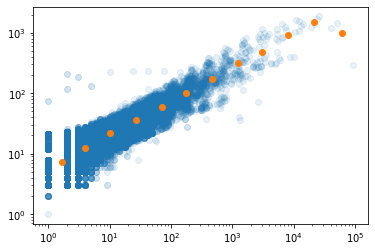

In [52]:
plt.xscale("log")
plt.yscale("log")
plt.scatter(blocks, pins, alpha = 0.1)
plt.scatter(bin_means[:,0], bin_means[:,1])

### Find rent exponent

In [53]:
log_bin_means = np.log(bin_means)

In [54]:
def trend_line(data):
    x = data[:,0]
    y = data[:,1]
    x_mean = x.mean()
    y_mean = y.mean()
    x_err = x-x_mean
    y_err = y-y_mean
    a = (x_err*y_err).sum()/ ((x_err)**2).sum()
    b = y_mean - x_mean*a
    first_point = [x[0], x[0]*a + b]
    last_point = [x[-1], x[-1]*a + b]
    
    #Error
    error = sum((y - (x*a + b))**2)/len(data)   
    
    return np.array([first_point, last_point]), a, b, error

In [55]:
trend_line(log_bin_means[:])

(array([[ 0.53167502,  2.14938848],
        [11.02040898,  7.60774327]]),
 0.5204016812923978,
 1.8727039045477922,
 0.0634876016874494)

In [56]:
int(n_bins/2)
n_selected_bins = 6
error_per_n_bins = [] ##Find the best error for sliding windows of selected number of bins
for n_selected_bins in range(int(3), n_bins+1):
    print(n_selected_bins)
    min_error = np.inf
    min_error_data = []
    for i in range(n_bins-n_selected_bins+1):
        line, slope, offset, error = trend_line(log_bin_means[i:i+n_selected_bins])
        if error < min_error:
            min_error = error
            min_error_data = log_bin_means[i:i+n_selected_bins]
    error_per_n_bins.append([n_selected_bins, min_error_data, min_error]) 
error_per_n_bins = np.array(error_per_n_bins, dtype=object)

3
4
5
6
7
8
9
10
11
12


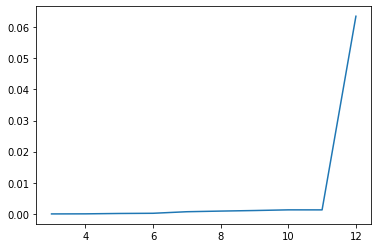

In [57]:
plt.plot(error_per_n_bins[:, 0], error_per_n_bins[:, -1])

In [58]:
error_per_n_bins[:, -1]

array([2.3656702284628372e-07, 2.3084518944006878e-05,
       0.0001409531968547212, 0.00020241826925331702,
       0.0007039509063945182, 0.0009086838208549404,
       0.0010887174368954958, 0.001304755845933559, 0.001297491254050468,
       0.0634876016874494], dtype=object)

In [62]:
##find best number of bins (to ommit rents first and second 'gebied' )
best_n_bins = 11 ## find this automatically ## find minimum and ... (? nog bedenken hoe juist)
selected_bins = error_per_n_bins[:,1][error_per_n_bins[:, 0] == best_n_bins][0]

trend_line(selected_bins)

(array([[0.53167502, 2.01638032],
        [9.95926279, 7.32327179]]),
 0.5629108528995665,
 1.7170946821939728,
 0.001297491254050468)

In [63]:
#Find best fit for 

0.5629108528995665


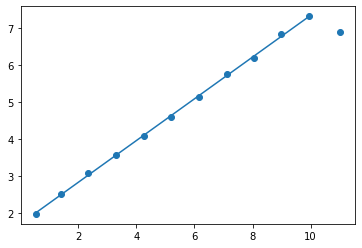

In [64]:
line, slope, offset, error = trend_line(selected_bins)
print(slope)
plt.scatter(log_bin_means[:,0], log_bin_means[:,1])

plt.plot(line[:,0], line[:,1])

In [65]:
trend_line(log_bin_means)

(array([[ 0.53167502,  2.14938848],
        [11.02040898,  7.60774327]]),
 0.5204016812923978,
 1.8727039045477922,
 0.0634876016874494)

In [66]:
trend_line(log_bin_means[1:-4])

(array([[1.39021415, 2.52047765],
        [7.12618881, 5.71632431]]),
 0.5571584335948216,
 1.7459081173537379,
 0.000932201513126011)

In [67]:
slope

0.5629108528995665

10 bins: 0.5845491182482381 

In [23]:
import pickle

In [28]:
# print(rent_data)
rent_data = [[[4,5], [9,10]], [[4,5], [9,10]]]
with open('test.rent', "wb") as fp:  # Pickling
    pickle.dump(rent_data, fp)

In [33]:
with open(os.path.join(bm_folder, 'rent', 'large.blif.rent'), "rb") as fp:   # Unpickling
    b = pickle.load(fp)

[[[8500, 499]],
 [[4025, 271], [4475, 339]],
 [[1816, 166], [2209, 247], [2195, 214], [2280, 266]],
 [[986, 109],
  [830, 115],
  [1210, 169],
  [999, 152],
  [1177, 113],
  [1018, 151],
  [1232, 182],
  [1048, 155]],
 [[475, 72],
  [511, 112],
  [390, 92],
  [440, 93],
  [546, 118],
  [664, 114],
  [501, 97],
  [498, 65],
  [644, 84],
  [533, 107],
  [541, 87],
  [477, 67],
  [604, 95],
  [628, 107],
  [570, 74],
  [478, 112]],
 [[221, 57],
  [254, 76],
  [267, 83],
  [244, 88],
  [175, 64],
  [215, 38],
  [220, 86],
  [220, 72],
  [295, 78],
  [251, 89],
  [301, 80],
  [363, 56],
  [273, 74],
  [228, 86],
  [264, 69],
  [234, 76],
  [347, 86],
  [297, 56],
  [240, 60],
  [293, 79],
  [270, 65],
  [271, 66],
  [252, 47],
  [225, 48],
  [302, 74],
  [302, 84],
  [314, 117],
  [314, 56],
  [285, 52],
  [285, 75],
  [242, 52],
  [236, 96]],
 [[111, 25],
  [110, 51],
  [127, 58],
  [127, 49],
  [121, 55],
  [146, 72],
  [122, 47],
  [122, 59],
  [91, 49],
  [84, 29],
  [103, 43],
  [112, 

In [31]:
os.path.split('/home/marieke/GNL_clone/benchmarks/blif/large.blif.rent')

('/home/marieke/GNL_clone/benchmarks/blif', 'large.blif.rent')